## Задание 3

Реализуйте один из оптимизаторов на выбор. Придумайте и напишите тесты для проверки выбранного оптимизатора. Проведите обучение нейрона из первого задания с использованием оптимизатора, а не ванильного градиентного спуска. Также опишите идею алгоритма (+1 балл). {*} Можете реализовать более 1 алгоритма. Каждый следующий даст 1 балл.

Варианты:

* Momentum (3 балла)
* Nesterov (3 балла)
* Adagrad (4 балла)
* Adadelta (4 балла)
* RMSProp (5 баллов)
* Adam (5 баллов)
* Nadam (6 баллов)
* NAG (6 баллов)
* AdamW (6 баллов)

In [ ]:
import unittest
import torch
import pandas as pd
import matplotlib.pyplot as plt


In [60]:
def sigmoid(z):
    return 1.0 / (1.0 + torch.exp(-z))


In [61]:
def load_and_prepare_data(year1, year2, normalize=True):
    """
    Загружает данные и подготавливает их для бинарной классификации двух лет.

    Args:
        year1: первый год для классификации (метка 0)
        year2: второй год для классификации (метка 1)
        normalize: нормализовать ли признаки (default: True)

    Returns:
        features: матрица признаков
        labels: бинарные метки (0 для year1, 1 для year2)
    """
    # Загружаем данные
    train_x = pd.read_csv('dataset4/train_x.csv', index_col=0)
    train_y = pd.read_csv('dataset4/train_y.csv', index_col=0)

    # Фильтруем данные для выбранных лет
    mask = (train_y['year'] == year1) | (train_y['year'] == year2)
    filtered_x = train_x[mask]
    filtered_y = train_y[mask]

    # Создаем бинарные метки: 0 для year1, 1 для year2
    labels = (filtered_y['year'] == year2).astype(int).values
    features = filtered_x.values

    # Нормализация признаков (стандартизация)
    if normalize:
        mean = features.mean(axis=0)
        std = features.std(axis=0)
        # Избегаем деления на ноль
        std[std == 0] = 1.0
        features = (features - mean) / std

    return features, labels


### Реализация оптимизаторов

In [62]:
class Optimizer:
    """Базовый класс для оптимизаторов."""

    def __init__(self, params, lr=0.01):
        self.params = list(params)
        self.lr = lr

    def step(self, grads):
        raise NotImplementedError


class Momentum(Optimizer):
    """
    Momentum (Метод импульсов).
    Идея: накапливать скользящее среднее градиентов (импульс) и двигаться в его направлении.
    Это помогает преодолевать локальные минимумы и ускоряет сходимость на пологих участках,
    сглаживая осцилляции.
    v_t = beta * v_{t-1} + g_t
    w_t = w_{t-1} - lr * v_t
    """

    def __init__(self, params, lr=0.01, beta=0.9):
        super().__init__(params, lr)
        self.beta = beta
        self.velocities = [torch.zeros_like(p) for p in params]

    def step(self, grads):
        for i, (param, grad) in enumerate(zip(self.params, grads)):
            self.velocities[i] = self.beta * self.velocities[i] + grad
            param -= self.lr * self.velocities[i]


class Nesterov(Optimizer):
    """
    Nesterov Accelerated Gradient (NAG).
    Идея: Сначала сделать шаг по импульсу, затем посчитать градиент в новой точке
    и сделать коррекцию. Это дает "заглядывание вперед".
    В реализации часто используется аппроксимация для стандартного цикла обучения:
    v_t = beta * v_{t-1} + g_t
    w_t = w_{t-1} - lr * (beta * v_t + g_t)
    """

    def __init__(self, params, lr=0.01, beta=0.9):
        super().__init__(params, lr)
        self.beta = beta
        self.velocities = [torch.zeros_like(p) for p in params]

    def step(self, grads):
        for i, (param, grad) in enumerate(zip(self.params, grads)):
            self.velocities[i] = self.beta * self.velocities[i] + grad
            update = self.beta * self.velocities[i] + grad
            param -= self.lr * update


class Adagrad(Optimizer):
    """
    Adagrad (Adaptive Gradient).
    Идея: Адаптировать скорость обучения для каждого параметра индивидуально.
    Параметры с частыми обновлениями (большими градиентами) получают меньший learning rate,
    а редкие - больший.
    G_t = G_{t-1} + g_t^2
    w_t = w_{t-1} - lr / sqrt(G_t + eps) * g_t
    """

    def __init__(self, params, lr=0.01, epsilon=1e-8):
        super().__init__(params, lr)
        self.epsilon = epsilon
        self.accumulated_grads = [torch.zeros_like(p) for p in params]

    def step(self, grads):
        for i, (param, grad) in enumerate(zip(self.params, grads)):
            self.accumulated_grads[i] += grad**2
            std = torch.sqrt(self.accumulated_grads[i] + self.epsilon)
            param -= (self.lr / std) * grad


class Adadelta(Optimizer):
    """
    Adadelta.
    Идея: Решает проблему монотонного убывания learning rate в Adagrad.
    Вместо полной суммы квадратов градиентов использует скользящее среднее.
    Также не требует явного задания learning rate (использует отношение RMS обновлений к RMS градиентов).
    """

    def __init__(self, params, lr=1.0, rho=0.9, epsilon=1e-6):
        super().__init__(params, lr)
        self.rho = rho
        self.epsilon = epsilon
        self.accumulated_grads = [torch.zeros_like(p) for p in params]
        self.accumulated_updates = [torch.zeros_like(p) for p in params]

    def step(self, grads):
        for i, (param, grad) in enumerate(zip(self.params, grads)):
            # Accumulate gradient squares
            self.accumulated_grads[i] = self.rho * self.accumulated_grads[i] + (1 - self.rho) * grad**2

            rms_grad = torch.sqrt(self.accumulated_grads[i] + self.epsilon)
            rms_update = torch.sqrt(self.accumulated_updates[i] + self.epsilon)

            update = (rms_update / rms_grad) * grad

            # Accumulate update squares
            self.accumulated_updates[i] = self.rho * self.accumulated_updates[i] + (1 - self.rho) * update**2

            param -= self.lr * update


class RMSProp(Optimizer):
    """
    RMSProp.
    Идея: Модификация Adagrad, использующая скользящее среднее квадратов градиентов.
    Позволяет бороться с затуханием learning rate, хорошо работает для нестационарных задач.
    E[g^2]_t = beta * E[g^2]_{t-1} + (1-beta) * g_t^2
    w_t = w_{t-1} - lr / sqrt(E[g^2]_t + eps) * g_t
    """

    def __init__(self, params, lr=0.01, beta=0.9, epsilon=1e-8):
        super().__init__(params, lr)
        self.beta = beta
        self.epsilon = epsilon
        self.accumulated_grads = [torch.zeros_like(p) for p in params]

    def step(self, grads):
        for i, (param, grad) in enumerate(zip(self.params, grads)):
            self.accumulated_grads[i] = self.beta * self.accumulated_grads[i] + (1 - self.beta) * grad**2
            param -= (self.lr / torch.sqrt(self.accumulated_grads[i] + self.epsilon)) * grad


class Adam(Optimizer):
    """
    Adam (Adaptive Moment Estimation).
    Идея: Сочетает идеи Momentum и RMSProp. Использует оценки первого (mean) и второго (variance)
    моментов градиентов.
    m_t = beta1 * m_{t-1} + (1-beta1) * g_t
    v_t = beta2 * v_{t-1} + (1-beta2) * g_t^2
    Коррекция смещения (bias correction) для начальных шагов.
    """

    def __init__(self, params, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(params, lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = [torch.zeros_like(p) for p in params]
        self.v = [torch.zeros_like(p) for p in params]
        self.t = 0

    def step(self, grads):
        self.t += 1
        for i, (param, grad) in enumerate(zip(self.params, grads)):
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * grad**2

            m_hat = self.m[i] / (1 - self.beta1**self.t)
            v_hat = self.v[i] / (1 - self.beta2**self.t)

            param -= self.lr * m_hat / (torch.sqrt(v_hat) + self.epsilon)


class Nadam(Optimizer):
    """
    Nadam (Nesterov-accelerated Adaptive Moment Estimation).
    Идея: Объединяет Adam и Nesterov momentum.
    Использует lookahead импульс для обновления параметров.
    """

    def __init__(self, params, lr=0.002, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(params, lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = [torch.zeros_like(p) for p in params]
        self.v = [torch.zeros_like(p) for p in params]
        self.t = 0

    def step(self, grads):
        self.t += 1
        for i, (param, grad) in enumerate(zip(self.params, grads)):
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * grad**2

            m_hat = self.m[i] / (1 - self.beta1**self.t)
            v_hat = self.v[i] / (1 - self.beta2**self.t)

            # Nesterov component
            m_term = self.beta1 * m_hat + (1 - self.beta1) * grad / (1 - self.beta1**self.t)

            param -= self.lr * m_term / (torch.sqrt(v_hat) + self.epsilon)


class AdamW(Optimizer):
    """
    AdamW (Adam with Decoupled Weight Decay).
    Идея: Исправляет реализацию L2 регуляризации в Adam.
    В Adam стандартная L2 регуляризация (добавление к градиенту) работает не так, как ожидается,
    из-за адаптивного learning rate. AdamW применяет weight decay непосредственно к весам.
    """

    def __init__(self, params, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, weight_decay=0.01):
        super().__init__(params, lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.weight_decay = weight_decay
        self.m = [torch.zeros_like(p) for p in params]
        self.v = [torch.zeros_like(p) for p in params]
        self.t = 0

    def step(self, grads):
        self.t += 1
        for i, (param, grad) in enumerate(zip(self.params, grads)):
            # Decoupled weight decay
            param.data.mul_(1 - self.lr * self.weight_decay)

            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * grad**2

            m_hat = self.m[i] / (1 - self.beta1**self.t)
            v_hat = self.v[i] / (1 - self.beta2**self.t)

            param -= self.lr * m_hat / (torch.sqrt(v_hat) + self.epsilon)


### Тесты

In [63]:
class TestOptimizers(unittest.TestCase):
    def _test_optimizer_convergence(self, optimizer_class, iterations=500, **kwargs):
        """
        Вспомогательный метод для проверки сходимости оптимизатора
        на простой квадратичной функции f(x) = (x - 5)^2.
        """
        x = torch.tensor([0.0], dtype=torch.float32)
        target = 5.0

        # Некоторые оптимизаторы требуют специфичные параметры
        optimizer = optimizer_class([x], **kwargs)

        initial_loss = (x - target)**2

        for _ in range(iterations):
            loss = (x - target)**2
            grad = 2 * (x - target)
            optimizer.step([grad])

        final_loss = (x - target)**2

        # Проверяем, что loss уменьшился значительно
        self.assertLess(final_loss, initial_loss, f"{optimizer_class.__name__} failed to decrease loss")
        # Проверяем, что пришли близко к оптимуму
        self.assertLess(abs(x.item() - target), 0.1,
                        f"{optimizer_class.__name__} failed to converge to target. Final x: {x.item()}")

    def test_momentum(self):
        self._test_optimizer_convergence(Momentum, lr=0.1, beta=0.9)

    def test_nesterov(self):
        self._test_optimizer_convergence(Nesterov, lr=0.1, beta=0.9)

    def test_adagrad(self):
        # Adagrad требует большего lr для этой задачи или больше итераций
        self._test_optimizer_convergence(Adagrad, lr=1.0)

    def test_adadelta(self):
        # Adadelta требует больше итераций для "разгона" из-за инициализации нулями
        self._test_optimizer_convergence(Adadelta, iterations=5000, lr=1.0, rho=0.9)

    def test_rmsprop(self):
        self._test_optimizer_convergence(RMSProp, lr=0.1)

    def test_adam(self):
        self._test_optimizer_convergence(Adam, lr=0.1)

    def test_nadam(self):
        self._test_optimizer_convergence(Nadam, lr=0.1)

    def test_adamw(self):
        # AdamW с weight decay будет сходиться не к 5, а к значению,
        # определяемому балансом между градиентом функции потерь и weight decay.
        # f(x) = (x-5)^2 + wd/2 * x^2 -> f'(x) = 2(x-5) + wd*x = 0 -> x(2+wd) = 10 -> x = 10/(2+wd)
        # При wd=0.01, x ~= 10/2.01 ~= 4.975
        self._test_optimizer_convergence(AdamW, lr=0.1, weight_decay=0.01)


unittest.main(argv=['first-arg-is-ignored'], exit=False)


........
----------------------------------------------------------------------
Ran 8 tests in 0.183s

OK


### Сравнение на нейроне из task1

Загрузка данных 2005 vs 2010...

Начало обучения разными оптимизаторами...
Training with Momentum...
  Final NLL: 0.4548
Training with Nesterov...
  Final NLL: 0.4548
Training with Adagrad...
  Final NLL: 0.4621
Training with Adadelta...
  Final NLL: 0.5729
Training with RMSProp...
  Final NLL: 0.479
Training with Adam...
  Final NLL: 0.4934
Training with Nadam...
  Final NLL: 0.6105
Training with AdamW...
  Final NLL: 0.4939

График сохранен в optimizers_comparison.png


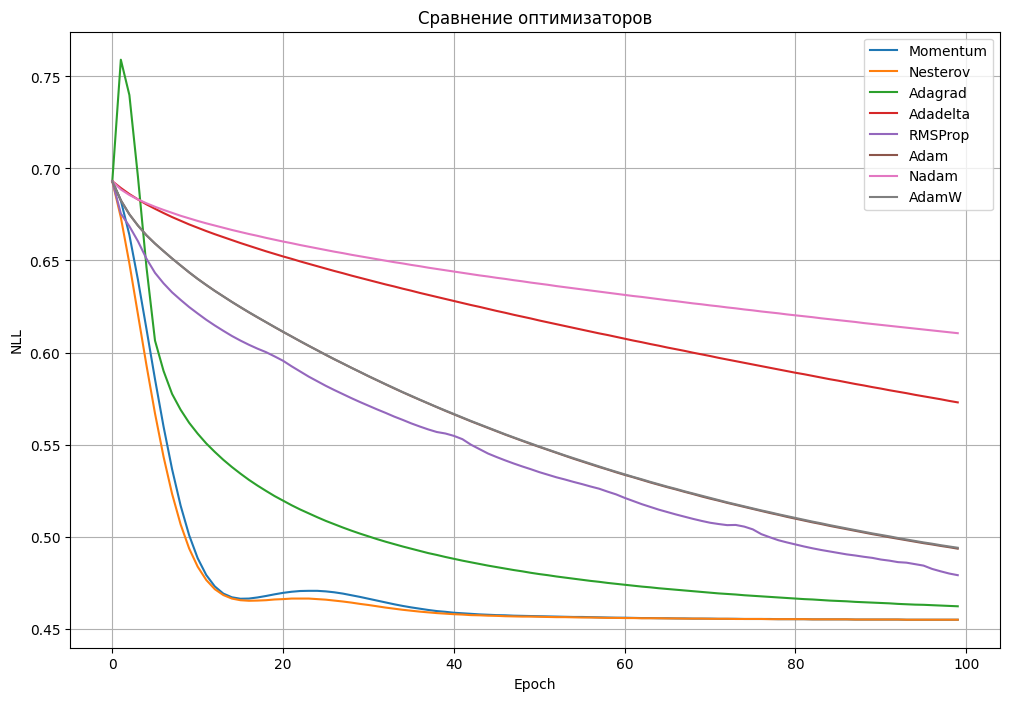

In [64]:
def train_neuron_with_optimizer(features, labels, initial_weights, initial_bias, optimizer_class, epochs, **optimizer_kwargs):
    """
    Обучение нейрона с использованием переданного класса оптимизатора.
    """
    X = torch.tensor(features, dtype=torch.float32)
    y = torch.tensor(labels, dtype=torch.float32)

    # Клонируем, чтобы не менять исходные данные
    weights = torch.tensor(initial_weights, dtype=torch.float32).clone()
    bias = torch.tensor(initial_bias, dtype=torch.float32).clone()

    params = [weights, bias]
    optimizer = optimizer_class(params, **optimizer_kwargs)

    n_samples = X.shape[0]
    nll_values = []
    epsilon = 1e-15

    for epoch in range(epochs):
        # Forward
        z = torch.matmul(X, weights) + bias
        predictions = sigmoid(z)

        # NLL
        predictions_clipped = torch.clamp(predictions, epsilon, 1 - epsilon)
        nll = -torch.mean(y * torch.log(predictions_clipped) + (1 - y) * torch.log(1 - predictions_clipped))
        nll_values.append(round(nll.item(), 4))

        # Backward
        error = predictions - y
        grad_weights = torch.matmul(X.t(), error) / n_samples
        grad_bias = torch.mean(error)

        grads = [grad_weights, grad_bias]

        # Step
        optimizer.step(grads)

    return weights.tolist(), round(bias.item(), 4), nll_values

# Загрузка данных
year1, year2 = 2005, 2010
print(f"Загрузка данных {year1} vs {year2}...")
features, labels = load_and_prepare_data(year1, year2)

n_features = features.shape[1]
initial_weights = [0.0] * n_features
initial_bias = 0.0
epochs = 100

# Список оптимизаторов для сравнения
optimizers = [
	(Momentum, {"lr": 0.1, "beta": 0.9}, "Momentum"),
	(Nesterov, {"lr": 0.1, "beta": 0.9}, "Nesterov"),
	(Adagrad, {"lr": 0.1}, "Adagrad"),
	(Adadelta, {"lr": 1.0, "rho": 0.9}, "Adadelta"),
	(RMSProp, {"lr": 0.01}, "RMSProp"),
	(Adam, {"lr": 0.01}, "Adam"),
	(Nadam, {"lr": 0.002}, "Nadam"),
	(AdamW, {"lr": 0.01, "weight_decay": 0.01}, "AdamW")
]

results = {}

print("\nНачало обучения разными оптимизаторами...")
plt.figure(figsize=(12, 8))

for opt_class, opt_kwargs, name in optimizers:
	print(f"Training with {name}...")
	w, b, nll = train_neuron_with_optimizer(
		features, labels, initial_weights, initial_bias,
		opt_class, epochs, **opt_kwargs
	)
	results[name] = nll
	plt.plot(nll, label=name)
	print(f"  Final NLL: {nll[-1]}")

plt.xlabel('Epoch')
plt.ylabel('NLL')
plt.title('Сравнение оптимизаторов')
plt.legend()
plt.grid(True)
plt.savefig('optimizers_comparison.png')
print("\nГрафик сохранен в optimizers_comparison.png")
plt.show()
